In [21]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import random

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

import plotly.graph_objs as go
import plotly.express as px 

from kernels import *
from utils import *

In [22]:

def DDM(mu, sigma, dt, total_time, key, trials):
    num_trajectories = len(mu)
    num_steps = int(total_time / dt)
    x = jnp.zeros((num_trajectories, num_steps + 1))
    ls_RT = []
    ls_acc = []

    keys = random.split(key, num_trajectories)

    for i in range(num_trajectories):
        current_key = keys[i]
        for t in range(num_steps): 
            if jnp.abs(x[i, t]) < 1:
                normal_sample = random.normal(current_key, shape=())
                x = x.at[i, t + 1].set(x[i, t] + mu[i] * dt + sigma * jnp.sqrt(dt) * normal_sample)
                current_key, subkey = random.split(current_key)
            else:
                ls_RT.append(t)
                ls_acc.append(1 if jnp.sign(x[i, t]) == jnp.sign(mu[i]) else -1)
                
                x = x.at[i, t:].set(jnp.sign(x[i, t]))
                break
    return x, ls_RT, ls_acc

mu = np.array([-0.64, -0.32, -0.16, -0.08, -0.04, 0.0, 0.04, 0.08, 0.16, 0.32, 0.64])  
sigma = 0.35
dt = 0.1
total_time = 100
trials = 150

ls_RTs = []
ls_accs = []
paths = jnp.zeros((trials, len(mu), int(total_time / dt) + 1))
for i in range(trials):
    key = random.PRNGKey(42 + i)
    path, ls_RT, ls_acc = DDM(mu, sigma, dt, total_time, key, trials) 
    paths = paths.at[i].set(path)
    ls_RTs.append(ls_RT)
    ls_accs.append(ls_acc)

accs = jnp.array(ls_accs)
RTs = jnp.array(ls_RTs)
paths = paths[:,:, :jnp.max(RTs)]
#paths_motion_on = paths[:,:, :jnp.min(RTs)]

# single_trial = False
# if single_trial:
#     paths_run = paths.reshape(-1, jnp.max(RTs))
# else:
#     paths_run = jnp.mean(paths, axis=0)#[jnp.newaxis,:,:]

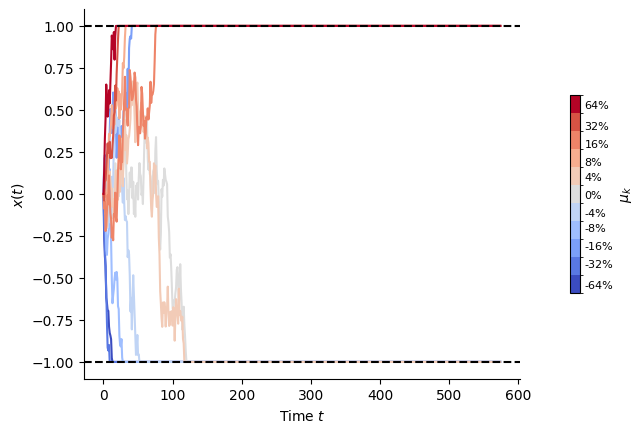

In [3]:

fig, ax = plt.subplots()
#times = np.linspace(0, total_time, int(total_time / dt) + 1)

boundaries = np.concatenate(([mu[0] - (mu[1] - mu[0])/2], (mu[:-1] + mu[1:])/2, [mu[-1] + (mu[-1] - mu[-2])/2]))
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(mu))
cmap = plt.get_cmap('coolwarm', len(mu))

for i, m in enumerate(mu):
    ax.plot(paths[3, i, :], color=cmap(norm(m)))

ax.axhline(y=1, color='black', linestyle='--')
ax.axhline(y=-1, color='black', linestyle='--')
ax.set_xlabel('Time $t$')
ax.set_ylabel(r'$x(t)$')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
 
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1, ticks=mu)
cbar.ax.tick_params(size=0) 
cbar.set_label('$\mu_k$')
cbar.set_ticklabels([f'{100*m:.0f}%' for m in mu], fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [4]:
def parametric_curve_v(x, mu):
    val = len(mu)//2
    x_1 = x[:,:val][:, ::-1]
    x_2 = x[:,val+1:]
    return x_1, x_2

RTs_1, RTs_2 = parametric_curve_v(RTs, mu)
accs_1, accs_2 = parametric_curve_v(accs, mu)

val = len(mu)//2
RTs_p = (RTs_1 + RTs_2) /2 
RTs_p = jnp.concatenate((RTs[:,val][:,jnp.newaxis], RTs_p), axis=1)

p_correct_1 = (jnp.sum(accs_1 == 1, axis=0) / accs_1.shape[0]) * 100
p_correct_2 = (jnp.sum(accs_2 == 1, axis=0) / accs_2.shape[0]) * 100
p_correct = (p_correct_1 + p_correct_2) /2 
p_correct = jnp.concatenate((jnp.array([50]), p_correct), axis=0)

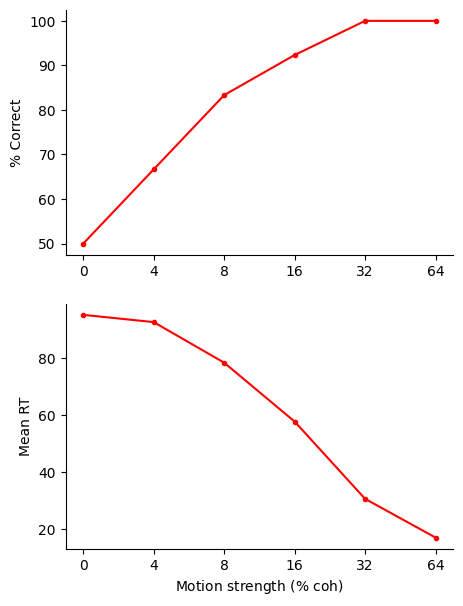

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(5,7))

axs[0].plot(p_correct, marker='.', color='r' )
axs[0].set_ylabel('% Correct')
axs[1].plot(jnp.mean(RTs_p, axis=0), marker='.', color='r')
axs[1].set_ylabel('Mean RT')
axs[1].set_xlabel('Motion strength ($\%$ coh)')
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ticks = np.arange(len(mu[val:]))  
    tick_labels = [f"{int(x * 100)}" for x in mu[val:]]  
    ax.set_xticks(ticks)  
    ax.set_xticklabels(tick_labels)  



In [23]:
def project(paths, proj_dims = 10):
    proj_matrix = random.normal(key, (proj_dims, 1))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                                        #(N',N)
    return jnp.einsum('dn,lknt->lkdt', proj_matrix, paths[:,:,jnp.newaxis,:])           #(trial, K, N=1, T)

def relu(x):
    return jnp.maximum(0, x)

def add_low_rank_noise(X, key1, key2, proj_dims = 3, sigma = 0.75 ):
    trials, K, N, T = X.shape    
    B = random.normal(key1, (N, proj_dims))
    B, _ = jnp.linalg.qr(B)

    epsilon_t = random.normal(key2, (trials, K, T, proj_dims)) * sigma  
    noise = jnp.einsum('lktd,nd->lknt', epsilon_t, B)             
    
    X += noise                                                   
    return X


neural_traces = relu(project(paths[:,:,:]))
neural_traces = neural_traces * 10

# noise = random.normal(key, (X.shape)) / 1000
# X += noise
key = random.PRNGKey(42)
key, subkey = random.split(key)
neural_traces = add_low_rank_noise(neural_traces, key, subkey)        #(trials, K, N, T)

X = jnp.mean( neural_traces, axis=0 )
#X = neural_traces.squeeze()
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)               
A = A.reshape(N,-1)      

d = 3

In [24]:

c = 40
kernel_function = K_X_Y_squared_exponential

from kernel_sca_inducing_points import *
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=300, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

Iteration 0, S: 20.80484962463379, S_ratio: 0.02148829773068428
Iteration 10, S: 164.9449920654297, S_ratio: 0.060045093297958374
Iteration 20, S: 486.59478759765625, S_ratio: 0.07740465551614761
Iteration 30, S: 1303.963623046875, S_ratio: 0.1138346865773201
Iteration 40, S: 1891.8399658203125, S_ratio: 0.11754429340362549
Iteration 50, S: 2508.619140625, S_ratio: 0.12229219079017639
Iteration 60, S: 3315.44482421875, S_ratio: 0.12521305680274963
Iteration 70, S: 3684.363037109375, S_ratio: 0.11942321062088013
Iteration 80, S: 4433.0078125, S_ratio: 0.13160079717636108
Iteration 90, S: 3970.8271484375, S_ratio: 0.13412036001682281
Iteration 100, S: 3930.799072265625, S_ratio: 0.1388212889432907
Iteration 110, S: 5742.23193359375, S_ratio: 0.13608668744564056
Iteration 120, S: 5356.10205078125, S_ratio: 0.15062490105628967
Iteration 130, S: 6175.529296875, S_ratio: 0.13502193987369537
Iteration 140, S: 4805.193359375, S_ratio: 0.1400354504585266
Iteration 150, S: 5513.734375, S_ratio: 

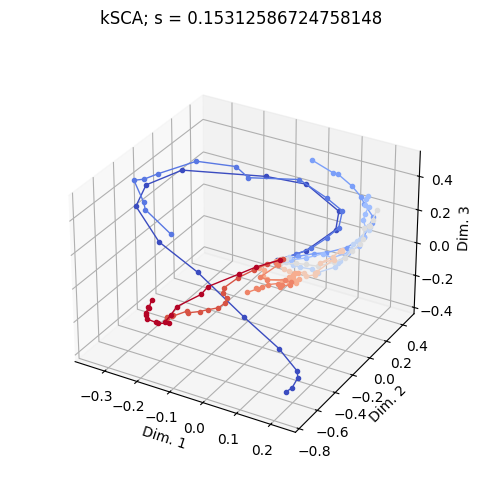

<Figure size 640x480 with 0 Axes>

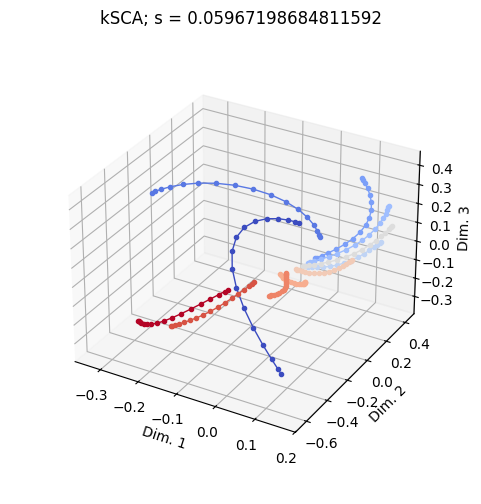

In [25]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u, _  = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

for i in range(Y.shape[0]):
    #Y = Y[:,:,:jnp.array(RTs).reshape(-1)[i]]
    Y = Y[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]

plot_3D_K_coded(Y, elevation=10, azimuth=60)

Y_smoothed = apply_gaussian_smoothing(Y, sigma=4)
plt.figure()
plot_3D_K_coded(Y_smoothed)

# plot_3D(Y[:,:,:])
# plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

In [26]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()

Iteration 0, S: 1083.801513671875, S_ratio: 0.00012587325181812048
Iteration 10, S: 1961.164794921875, S_ratio: 8.304127550218254e-05
Iteration 20, S: 2886.86083984375, S_ratio: 5.002267789677717e-05
Iteration 30, S: 4938.1376953125, S_ratio: 5.872195106348954e-05
Iteration 40, S: 6566.70703125, S_ratio: 4.528660429059528e-05
Iteration 50, S: 18992.33203125, S_ratio: 9.18144651222974e-05
Iteration 60, S: 11560.5498046875, S_ratio: 6.92418179824017e-05
Iteration 70, S: 11848.908203125, S_ratio: 5.2366467571118847e-05
Iteration 80, S: 18546.6875, S_ratio: 7.651290798094124e-05
Iteration 90, S: 6009.65087890625, S_ratio: 2.828118158504367e-05
Iteration 100, S: 10394.009765625, S_ratio: 4.4691292714560404e-05
Iteration 110, S: 15964.5693359375, S_ratio: 6.60349614918232e-05
Iteration 120, S: 5819.5966796875, S_ratio: 2.257876258227043e-05
Iteration 130, S: 19569.048828125, S_ratio: 7.643738354090601e-05
Iteration 140, S: 1166.540771484375, S_ratio: 4.371209797682241e-06
Iteration 150, S: 1

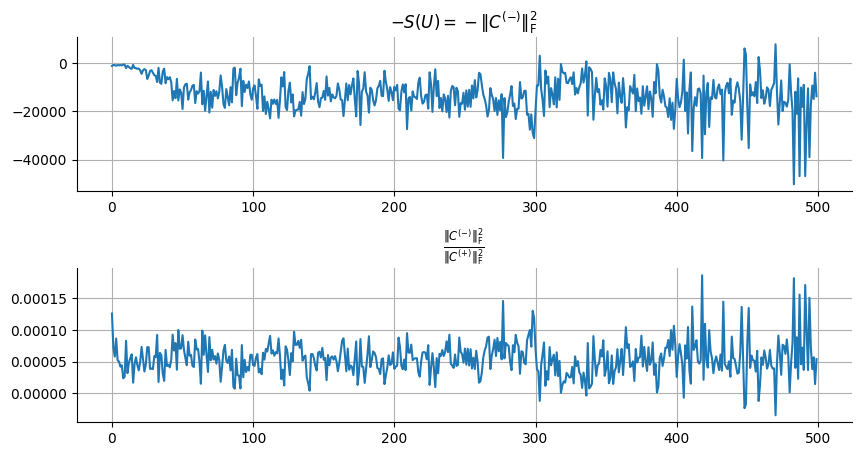

In [27]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X), d=d, learning_rate=0.01, iterations=500) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )



Text(0.5, 0.92, 'SCA; s = -2.0461886379052885e-05')

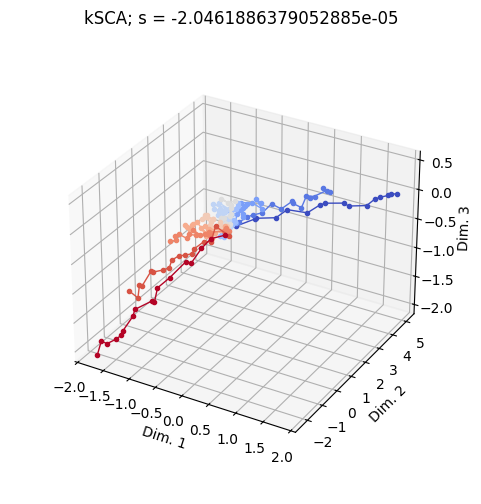

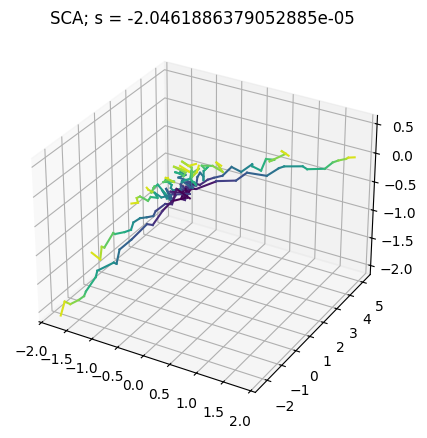

In [28]:
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X))


for i in range(Y.shape[0]):
    #Y = Y[:,:,:jnp.array(RTs).reshape(-1)[i]]
    Y = Y[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]
    
plot_3D_K_coded(Y)

plot_3D(Y[:,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

In [30]:

def get_pca(X_train, X_test=None, num_pcs = 2, test=False):
    _, N, T = X_train.shape
    X_pca_train = center(X_train).swapaxes(1,2).reshape(-1, N)

    
    pca = PCA(num_pcs)
    if test:
        X_pca_test = center(X_test).swapaxes(1,2).reshape(-1, N)
        Y_pca = pca.fit(X_pca_train).transform(X_pca_test)
    else:
        Y_pca = pca.fit(X_pca_train).transform(X_pca_train)
    PCs = pca.components_
    Y_pca = Y_pca.reshape(-1, T, num_pcs).swapaxes(1,2)
    return Y_pca, PCs

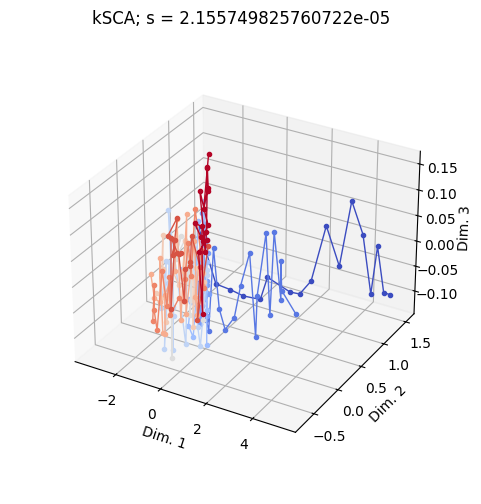

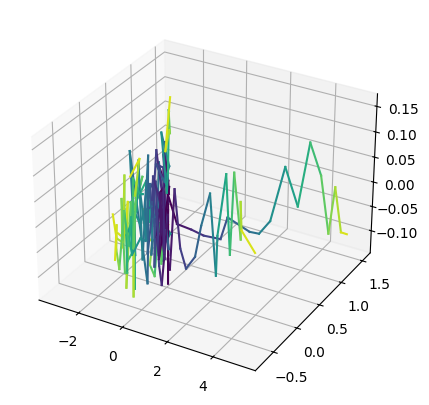

In [31]:
""" PCA """
Y_pca, PCs = get_pca(X, num_pcs=d)

for i in range(Y_pca.shape[0]):
    Y_pca = Y_pca[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]
    
plot_3D_K_coded(jnp.array(Y_pca))

plot_3D(Y_pca)

In [45]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()